**NAMA : LIA ALYANI**

**NIM : 121450138**

**TUGAS TEKNOLOGI BASIS DATA RA**

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Dalam artikel tersebut, disebutkan bahwa terdapat tiga metode utama untuk menyimpan dan mengakses gambar menggunakan Python, yaitu melalui format PNG, lightning memory-mapped databases (LMDB), dan hierarchical data format (HDF5). Penelitian dilakukan dengan melakukan langkah-langkah eksperimental, mulai dari persiapan, penyimpanan satu gambar, penyimpanan banyak gambar, pembacaan satu gambar, pembacaan banyak gambar, hingga evaluasi. Fokus utama dari artikel ini adalah membandingkan proses penyimpanan dan pengaksesan gambar menggunakan ketiga metode tersebut.

Dalam langkah persiapan, dataset gambar yang digunakan berasal dari Canadian Institute for Advanced Research (CIFAR-10), yang terdiri dari 60.000 gambar berwarna dengan ukuran 32x32 piksel.

# Tiga Cara Menyimpan dan Mengakses Banyak Gambar dalam Python

In [15]:
import numpy as np
import pickle
from pathlib import Path

# Path to the unzipped CIFAR data
data_dir = Path("/content/drive/MyDrive/cifar-10-batches-py")

# Unpickle function provided by the CIFAR hosts
def unpickle(file):
    with open(file, "rb") as fo:
        dict = pickle.load(fo, encoding="bytes")
    return dict

images, labels = [], []
for batch in data_dir.glob("data_batch_*"):
    batch_data = unpickle(batch)
    for i, flat_im in enumerate(batch_data[b"data"]):
        im_channels = []
        # Each image is flattened, with channels in order of R, G, B
        for j in range(3):
            im_channels.append(
                flat_im[j * 1024 : (j + 1) * 1024].reshape((32, 32))
            )
        # Reconstruct the original image
        images.append(np.dstack((im_channels)))
        # Save the label
        labels.append(batch_data[b"labels"][i])

print("Loaded CIFAR-10 training set:")
print(f" - np.shape(images)     {np.shape(images)}")
print(f" - np.shape(labels)     {np.shape(labels)}")

Loaded CIFAR-10 training set:
 - np.shape(images)     (50000, 32, 32, 3)
 - np.shape(labels)     (50000,)


Terdapat banyak cara untuk mengakses dan menyimpan data, khususnya data gambar, di Python. Library seperti PIL memungkinkan untuk memproses dan memodelkan data gambar, bahkan dalam jumlah yang besar seperti ratusan gambar. Namun, semakin besar volume data, semakin tinggi beban kerja algoritma. Dalam kasus pelatihan model seperti Convolutional Neural Networks (CNN), penanganan volume data yang besar memerlukan pendekatan yang efisien. Salah satu tantangan utamanya adalah waktu yang dibutuhkan untuk memuat data yang besar ke dalam memori untuk pelatihan. Proses pemrosesan dalam batch bisa memakan waktu yang signifikan dan kurang efisien.

In [16]:
pip install Pillow #menginstallpillow untuk image manipulation

## Start With LMDB ( Lightning Memory - Mapped Database)

Keunggulan utama dari LMDB terletak pada kemampuannya untuk memetakan file langsung ke dalam memori. Hal ini memungkinkan LMDB untuk mengembalikan penunjuk langsung ke alamat memori dari kunci dan nilai, tanpa perlu melakukan proses penyalinan data di dalam memori seperti yang umumnya dilakukan oleh basis data lain.

In [17]:
pip install lmdb

## Start With HDF5 ( Hierarchical Data Format)
File HDF terdiri dari dua jenis objek:

Dataset
Kelompok

File HDF5 terdiri dari kumpulan data yang mencakup array multidimensi. HDF5 dapat menyimpan array dengan ukuran dan tipe data apa pun. Selain itu, HDF5 juga menggunakan konsep grup yang merupakan koleksi dari kumpulan data tersebut.

In [18]:
pip install h5py

## Menyimpan Satu Gambar

Karena lima kumpulan CIFAR-10 berjumlah 50.000 gambar, dapat digunakan setiap gambar dua kali untuk mendapatkan 100.000 gambar. dan memerlukan folder untuk menyimpan file gambar dan path direktori dari ketiga variabel,syntax untuk menyimpan gambar sebagai berikut

In [19]:
from pathlib import Path

disk_dir = Path("data/disk/")
lmdb_dir = Path("data/lmdb/")
hdf5_dir = Path("data/hdf5/")

In [20]:
# membuat folder
disk_dir.mkdir(parents=True, exist_ok=True)
lmdb_dir.mkdir(parents=True, exist_ok=True)
hdf5_dir.mkdir(parents=True, exist_ok=True)

## Menyimpan ke Disk

Gambar yang sebelumya terdapat dalam memory dalam bentuk numpy array akan disimpan ke disk sebagai format png.

In [21]:
from PIL import Image
import csv

def store_single_disk(image, image_id, label):
    """ Stores a single image as a .png file on disk.
        Parameters:
        ---------------
        image       image array, (32, 32, 3) to be stored
        image_id    integer unique ID for image
        label       image label
    """
    Image.fromarray(image).save(disk_dir / f"{image_id}.png")

    with open(disk_dir / f"{image_id}.csv", "wt") as csvfile:
        writer = csv.writer(
            csvfile, delimiter=" ", quotechar="|", quoting=csv.QUOTE_MINIMAL
        )
        writer.writerow([label])

Untuk mengatasi masalah penyimpanan gambar ke disk dan hanya mempertahankan metadata yang relevan, salah satu solusinya adalah dengan mengkodekan metadata tersebut ke dalam file gambar itu sendiri. Dengan cara ini, kebutuhan untuk menyimpan metadata dalam file terpisah dapat dihilangkan.

## Menyimpan Ke LMDB
LMDB adalah sistem penyimpanan di mana setiap entri disimpan sebagai array byte. Dalam skenario ini, setiap gambar akan memiliki identifikasi unik sebagai kunci, dengan gambar itu sendiri sebagai nilai. Kedua nilai tersebut harus berupa string. Untuk melakukan serialisasi, Anda bisa menggunakan library "pickle", yang memungkinkan semua objek Python untuk diserialisasi. Oleh karena itu, direkomendasikan untuk menyertakan metadata gambar dalam basis data.

Metode ini membantu menghindari kesulitan saat perlu menyematkan kembali metadata ke gambar saat memuat kumpulan data dari disk. Di bawah ini adalah contoh kode untuk membuat kelas yang menyimpan gambar dan metadata-nya.

In [22]:
class CIFAR_Image:
    def __init__(self, image, label):
        # Dimensions of image for reconstruction - not really necessary
        # for this dataset, but some datasets may include images of
        # varying sizes
        self.channels = image.shape[2]
        self.size = image.shape[:2]

        self.image = image.tobytes()
        self.label = label

    def get_image(self):
        """ Returns the image as a numpy array. """
        image = np.frombuffer(self.image, dtype=np.uint8)
        return image.reshape(*self.size, self.channels)

Saat menggunakan LMDB, basis data baru harus mengetahui perkiraan jumlah memori yang akan digunakan, yang disebut "map_size", karena LMDB memetakan basis data ke dalam memori. Meskipun hal ini mudah dalam beberapa kasus, namun bisa menjadi masalah dalam situasi tertentu.

Berikut kode untuk menyimpan satu gambar dengan LMDB

In [23]:
import lmdb
import pickle

def store_single_lmdb(image, image_id, label):
    """ Stores a single image to a LMDB.
        Parameters:
        ---------------
        image       image array, (32, 32, 3) to be stored
        image_id    integer unique ID for image
        label       image label
    """
    map_size = image.nbytes * 10

    # Create a new LMDB environment
    env = lmdb.open(str(lmdb_dir / f"single_lmdb"), map_size=map_size)

    # Start a new write transaction
    with env.begin(write=True) as txn:
        # All key-value pairs need to be strings
        value = CIFAR_Image(image, label)
        key = f"{image_id:08}"
        txn.put(key.encode("ascii"), pickle.dumps(value))
    env.close()

## Storing With HDF5

Berikut kode penyimpanan HDF5 dengan dua data.

In [24]:
import h5py

def store_single_hdf5(image, image_id, label):
    """ Stores a single image to an HDF5 file.
        Parameters:
        ---------------
        image       image array, (32, 32, 3) to be stored
        image_id    integer unique ID for image
        label       image label
    """
    # Create a new HDF5 file
    file = h5py.File(hdf5_dir / f"{image_id}.h5", "w")

    # Create a dataset in the file
    dataset = file.create_dataset(
        "image", np.shape(image), h5py.h5t.STD_U8BE, data=image
    )
    meta_set = file.create_dataset(
        "meta", np.shape(label), h5py.h5t.STD_U8BE, data=label
    )
    file.close()

## Storing a single image

Membuat sebuah dictionary yang mencakup 3 teknik penyimpanan gambar

In [25]:
_store_single_funcs = dict(
    disk=store_single_disk, lmdb=store_single_lmdb, hdf5=store_single_hdf5
)

In [26]:
from timeit import timeit

store_single_timings = dict()

for method in ("disk", "lmdb", "hdf5"):
    t = timeit(
        "_store_single_funcs[method](image, 0, label)",
        setup="image=images[0]; label=labels[0]",
        number=1,
        globals=globals(),
    )
    store_single_timings[method] = t
    print(f"Method: {method}, Time usage: {t}")

Method: disk, Time usage: 0.060984258000189584
Method: lmdb, Time usage: 0.017186660000334086
Method: hdf5, Time usage: 0.011729855999874417


Didapatkan hasil metode Disk memakan waktu 0.060984258000189584 detik, LMBD selama 0.017186660000334086 detik dan HDF5 selama 0.011729855999874417 detik.

## Storing Many Images

Untuk melakukan menyimpan banyak gambar dilakukan pengkodean sebagai berikut.

In [27]:
def store_many_disk(images, labels):
    """ Stores an array of images to disk
        Parameters:
        ---------------
        images       images array, (N, 32, 32, 3) to be stored
        labels       labels array, (N, 1) to be stored
    """
    num_images = len(images)

    # Save all the images one by one
    for i, image in enumerate(images):
        Image.fromarray(image).save(disk_dir / f"{i}.png")

    # Save all the labels to the csv file
    with open(disk_dir / f"{num_images}.csv", "w") as csvfile:
        writer = csv.writer(
            csvfile, delimiter=" ", quotechar="|", quoting=csv.QUOTE_MINIMAL
        )
        for label in labels:
            # This typically would be more than just one value per row
            writer.writerow([label])

def store_many_lmdb(images, labels):
    """ Stores an array of images to LMDB.
        Parameters:
        ---------------
        images       images array, (N, 32, 32, 3) to be stored
        labels       labels array, (N, 1) to be stored
    """
    num_images = len(images)

    map_size = num_images * images[0].nbytes * 10

    # Create a new LMDB DB for all the images
    env = lmdb.open(str(lmdb_dir / f"{num_images}_lmdb"), map_size=map_size)

    # Same as before — but let's write all the images in a single transaction
    with env.begin(write=True) as txn:
        for i in range(num_images):
            # All key-value pairs need to be Strings
            value = CIFAR_Image(images[i], labels[i])
            key = f"{i:08}"
            txn.put(key.encode("ascii"), pickle.dumps(value))
    env.close()

def store_many_hdf5(images, labels):
    """ Stores an array of images to HDF5.
        Parameters:
        ---------------
        images       images array, (N, 32, 32, 3) to be stored
        labels       labels array, (N, 1) to be stored
    """
    num_images = len(images)

    # Create a new HDF5 file
    file = h5py.File(hdf5_dir / f"{num_images}_many.h5", "w")

    # Create a dataset in the file
    dataset = file.create_dataset(
        "images", np.shape(images), h5py.h5t.STD_U8BE, data=images
    )
    meta_set = file.create_dataset(
        "meta", np.shape(labels), h5py.h5t.STD_U8BE, data=labels
    )
    file.close()

## Preparing Dataset

melakukan cutoff yang bernilai 10, 100, 1000, 10000, dan 100000 gambar

In [28]:
cutoffs = [10, 100, 1000, 10000, 100000]

# Let's double our images so that we have 100,000
images = np.concatenate((images, images), axis=0)
labels = np.concatenate((labels, labels), axis=0)

# Make sure you actually have 100,000 images and labels
print(np.shape(images))
print(np.shape(labels))

(100000, 32, 32, 3)
(100000,)


## Experiment for Storing Many Images

setelah itu melakukan eksperiment untuk menyimpan banyak gambar

In [30]:
_store_many_funcs = dict(
    disk=store_many_disk, lmdb=store_many_lmdb, hdf5=store_many_hdf5
)

from timeit import timeit

store_many_timings = {"disk": [], "lmdb": [], "hdf5": []}

for cutoff in cutoffs:
    for method in ("disk", "lmdb", "hdf5"):
        t = timeit(
            "_store_many_funcs[method](images_, labels_)",
            setup="images_=images[:cutoff]; labels_=labels[:cutoff]",
            number=1,
            globals=globals(),
        )
        store_many_timings[method].append(t)

        # Print out the method, cutoff, and elapsed time
        print(f"Method: {method}, Time usage: {t}")

Method: disk, Time usage: 0.012574804999985645
Method: lmdb, Time usage: 0.0074170439997942594
Method: hdf5, Time usage: 0.00227957700008119
Method: disk, Time usage: 0.06729665400007434
Method: lmdb, Time usage: 0.013505107000128191
Method: hdf5, Time usage: 0.0030577219999941008
Method: disk, Time usage: 0.6516917849999118
Method: lmdb, Time usage: 0.06246709100014414
Method: hdf5, Time usage: 0.008764534999954776
Method: disk, Time usage: 5.286024412000188
Method: lmdb, Time usage: 0.464327479000076
Method: hdf5, Time usage: 0.07172583699957613
Method: disk, Time usage: 55.601886037999975
Method: lmdb, Time usage: 8.308399344000009
Method: hdf5, Time usage: 0.8323716119998608


penyimpanan gambar disimpan 5 kali. untuk memilih model yang terbaik dapat di lakukan pengecakan dari ketiga metode tersebut pada setiap cutoff, metode yang terbaik ialah metode dengan time usage yang lebih kecil.

<ipython-input-31-99d89538a067>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


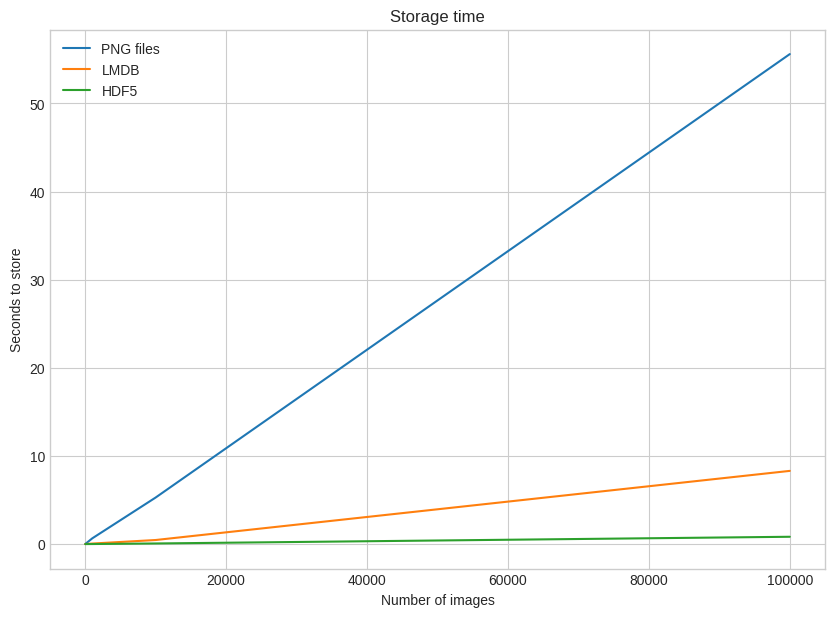

<ipython-input-31-99d89538a067>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


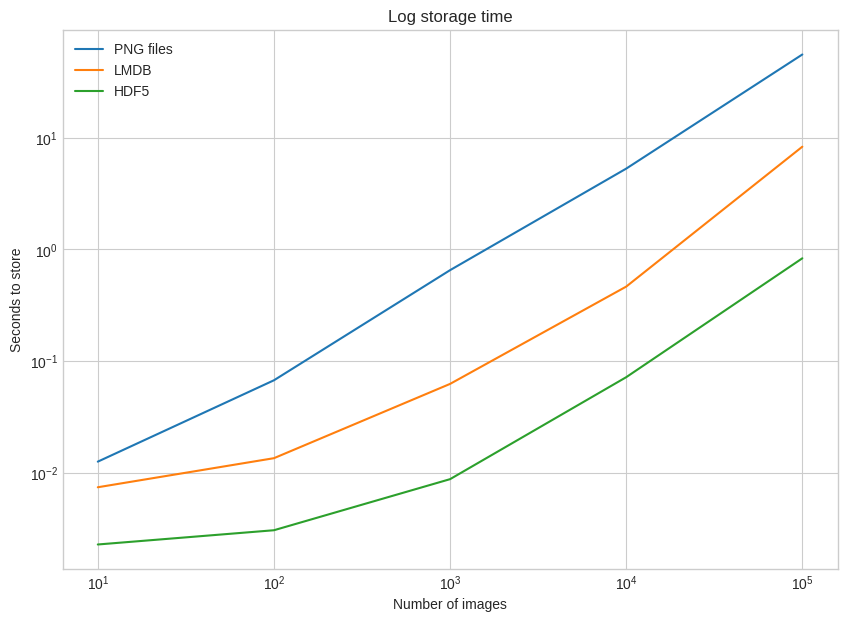

In [31]:
import matplotlib.pyplot as plt

def plot_with_legend(
    x_range, y_data, legend_labels, x_label, y_label, title, log=False
):
    """ Displays a single plot with multiple datasets and matching legends.
        Parameters:
        --------------
        x_range         list of lists containing x data
        y_data          list of lists containing y values
        legend_labels   list of string legend labels
        x_label         x axis label
        y_label         y axis label
    """
    plt.style.use("seaborn-whitegrid")
    plt.figure(figsize=(10, 7))

    if len(y_data) != len(legend_labels):
        raise TypeError(
            "Error: number of data sets does not match number of labels."
        )

    all_plots = []
    for data, label in zip(y_data, legend_labels):
        if log:
            temp, = plt.loglog(x_range, data, label=label)
        else:
            temp, = plt.plot(x_range, data, label=label)
        all_plots.append(temp)

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(handles=all_plots)
    plt.show()

# Getting the store timings data to display
disk_x = store_many_timings["disk"]
lmdb_x = store_many_timings["lmdb"]
hdf5_x = store_many_timings["hdf5"]

plot_with_legend(
    cutoffs,
    [disk_x, lmdb_x, hdf5_x],
    ["PNG files", "LMDB", "HDF5"],
    "Number of images",
    "Seconds to store",
    "Storage time",
    log=False,
)

plot_with_legend(
    cutoffs,
    [disk_x, lmdb_x, hdf5_x],
    ["PNG files", "LMDB", "HDF5"],
    "Number of images",
    "Seconds to store",
    "Log storage time",
    log=True,
)

## Reading a Single Images

Untuk dapat membaca dari disk dengan format png digunakan syntax berikut

In [33]:
def read_single_disk(image_id):
    """ Stores a single image to disk.
        Parameters:
        ---------------
        image_id    integer unique ID for image

        Returns:
        ----------
        image       image array, (32, 32, 3) to be stored
        label       associated meta data, int label
    """
    image = np.array(Image.open(disk_dir / f"{image_id}.png"))

    with open(disk_dir / f"{image_id}.csv", "r") as csvfile:
        reader = csv.reader(
            csvfile, delimiter=" ", quotechar="|", quoting=csv.QUOTE_MINIMAL
        )
        label = int(next(reader)[0])

    return image, label

## Reading From LMDB

Untuk proses read dengan metode LMBD

In [34]:
def read_single_lmdb(image_id):
    """ Stores a single image to LMDB.
        Parameters:
        ---------------
        image_id    integer unique ID for image

        Returns:
        ----------
        image       image array, (32, 32, 3) to be stored
        label       associated meta data, int label
    """
    # Open the LMDB environment
    env = lmdb.open(str(lmdb_dir / f"single_lmdb"), readonly=True)

    # Start a new read transaction
    with env.begin() as txn:
        # Encode the key the same way as we stored it
        data = txn.get(f"{image_id:08}".encode("ascii"))
        # Remember it's a CIFAR_Image object that is loaded
        cifar_image = pickle.loads(data)
        # Retrieve the relevant bits
        image = cifar_image.get_image()
        label = cifar_image.label
    env.close()

    return image, label

## Reading From HDF5

In [35]:
def read_single_hdf5(image_id):
    """ Stores a single image to HDF5.
        Parameters:
        ---------------
        image_id    integer unique ID for image

        Returns:
        ----------
        image       image array, (32, 32, 3) to be stored
        label       associated meta data, int label
    """
    # Open the HDF5 file
    file = h5py.File(hdf5_dir / f"{image_id}.h5", "r+")

    image = np.array(file["/image"]).astype("uint8")
    label = int(np.array(file["/meta"]).astype("uint8"))

    return image, label

In [36]:
_read_single_funcs = dict(
    disk=read_single_disk, lmdb=read_single_lmdb, hdf5=read_single_hdf5
)

## Experiment for Reading a Single Image

In [37]:
from timeit import timeit

read_single_timings = dict()

for method in ("disk", "lmdb", "hdf5"):
    t = timeit(
        "_read_single_funcs[method](0)",
        setup="image=images[0]; label=labels[0]",
        number=1,
        globals=globals(),
    )
    read_single_timings[method] = t
    print(f"Method: {method}, Time usage: {t}")

Method: disk, Time usage: 0.002999725000336184
Method: lmdb, Time usage: 0.007998118000159593
Method: hdf5, Time usage: 0.002849938000053953


Didapatkan hasil bahwa proses read gambar dengan metode Disk menghabiskan waktu 0.002999725000336184 detik, LMBD 0.007998118000159593 detik dan HDF5 0.0.002849938000053953 detik.

## Reading Many Images

### Adjusting the Code for Many Images

In [38]:
def read_many_disk(num_images):
    """ Reads image from disk.
        Parameters:
        ---------------
        num_images   number of images to read

        Returns:
        ----------
        images      images array, (N, 32, 32, 3) to be stored
        labels      associated meta data, int label (N, 1)
    """
    images, labels = [], []

    # Loop over all IDs and read each image in one by one
    for image_id in range(num_images):
        images.append(np.array(Image.open(disk_dir / f"{image_id}.png")))

    with open(disk_dir / f"{num_images}.csv", "r") as csvfile:
        reader = csv.reader(
            csvfile, delimiter=" ", quotechar="|", quoting=csv.QUOTE_MINIMAL
        )
        for row in reader:
            labels.append(int(row[0]))
    return images, labels

def read_many_lmdb(num_images):
    """ Reads image from LMDB.
        Parameters:
        ---------------
        num_images   number of images to read

        Returns:
        ----------
        images      images array, (N, 32, 32, 3) to be stored
        labels      associated meta data, int label (N, 1)
    """
    images, labels = [], []
    env = lmdb.open(str(lmdb_dir / f"{num_images}_lmdb"), readonly=True)

    # Start a new read transaction
    with env.begin() as txn:
        # Read all images in one single transaction, with one lock
        # We could split this up into multiple transactions if needed
        for image_id in range(num_images):
            data = txn.get(f"{image_id:08}".encode("ascii"))
            # Remember that it's a CIFAR_Image object
            # that is stored as the value
            cifar_image = pickle.loads(data)
            # Retrieve the relevant bits
            images.append(cifar_image.get_image())
            labels.append(cifar_image.label)
    env.close()
    return images, labels

def read_many_hdf5(num_images):
    """ Reads image from HDF5.
        Parameters:
        ---------------
        num_images   number of images to read

        Returns:
        ----------
        images      images array, (N, 32, 32, 3) to be stored
        labels      associated meta data, int label (N, 1)
    """
    images, labels = [], []

    # Open the HDF5 file
    file = h5py.File(hdf5_dir / f"{num_images}_many.h5", "r+")

    images = np.array(file["/images"]).astype("uint8")
    labels = np.array(file["/meta"]).astype("uint8")

    return images, labels

_read_many_funcs = dict(
    disk=read_many_disk, lmdb=read_many_lmdb, hdf5=read_many_hdf5
)

### Experiment for Reading Many Images

In [39]:
from timeit import timeit

read_many_timings = {"disk": [], "lmdb": [], "hdf5": []}

for cutoff in cutoffs:
    for method in ("disk", "lmdb", "hdf5"):
        t = timeit(
            "_read_many_funcs[method](num_images)",
            setup="num_images=cutoff",
            number=1,
            globals=globals(),
        )
        read_many_timings[method].append(t)

        # Print out the method, cutoff, and elapsed time
        print(f"Method: {method}, No. images: {cutoff}, Time usage: {t}")

Method: disk, No. images: 10, Time usage: 0.011922941000193532
Method: lmdb, No. images: 10, Time usage: 0.0012311049999880197
Method: hdf5, No. images: 10, Time usage: 0.004308608999963326
Method: disk, No. images: 100, Time usage: 0.09547990300006859
Method: lmdb, No. images: 100, Time usage: 0.0027350039999873843
Method: hdf5, No. images: 100, Time usage: 0.0032038920003287785
Method: disk, No. images: 1000, Time usage: 0.6230934780001007
Method: lmdb, No. images: 1000, Time usage: 0.023417476999838982
Method: hdf5, No. images: 1000, Time usage: 0.008918160000121134
Method: disk, No. images: 10000, Time usage: 5.777562597999804
Method: lmdb, No. images: 10000, Time usage: 0.1727316989999963
Method: hdf5, No. images: 10000, Time usage: 0.03943293600013931
Method: disk, No. images: 100000, Time usage: 31.413787462000073
Method: lmdb, No. images: 100000, Time usage: 1.4483320590002222
Method: hdf5, No. images: 100000, Time usage: 1.3208534979999058


dapat dilihat bahwa metode lmdb lebih cepat membaca image ketimbang metode disk dan hdfs

<ipython-input-32-99d89538a067>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


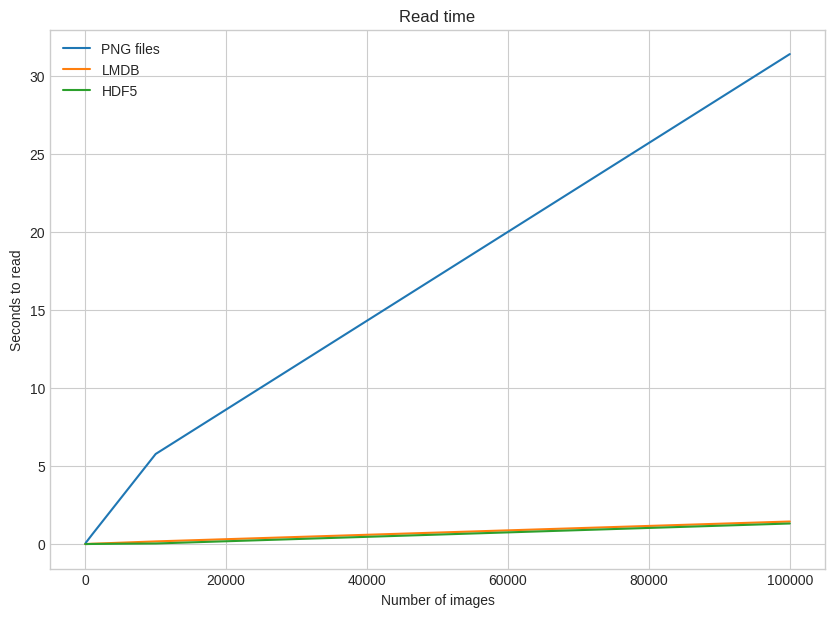

<ipython-input-32-99d89538a067>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


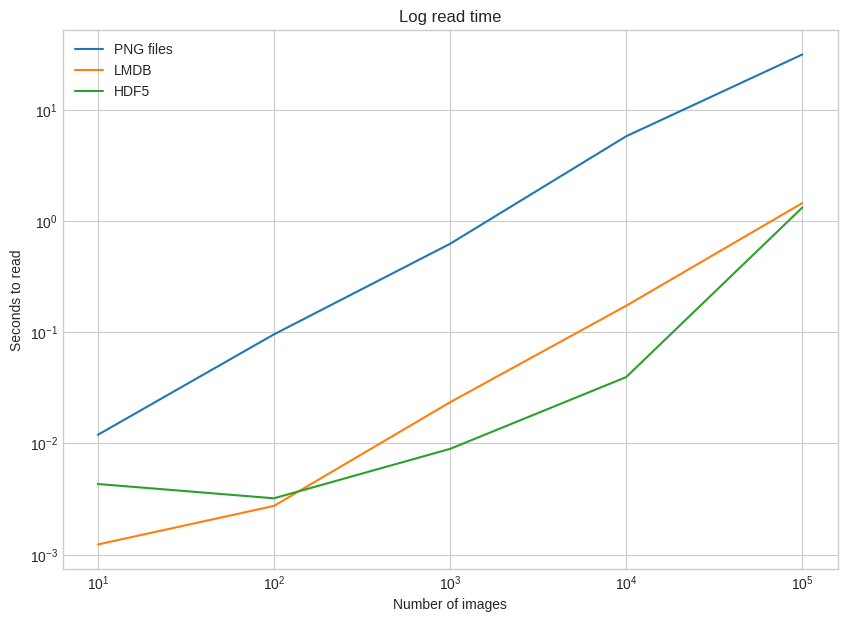

In [40]:
disk_x_r = read_many_timings["disk"]
lmdb_x_r = read_many_timings["lmdb"]
hdf5_x_r = read_many_timings["hdf5"]

plot_with_legend(
    cutoffs,
    [disk_x_r, lmdb_x_r, hdf5_x_r],
    ["PNG files", "LMDB", "HDF5"],
    "Number of images",
    "Seconds to read",
    "Read time",
    log=False,
)

plot_with_legend(
    cutoffs,
    [disk_x_r, lmdb_x_r, hdf5_x_r],
    ["PNG files", "LMDB", "HDF5"],
    "Number of images",
    "Seconds to read",
    "Log read time",
    log=True,
)

<ipython-input-32-99d89538a067>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


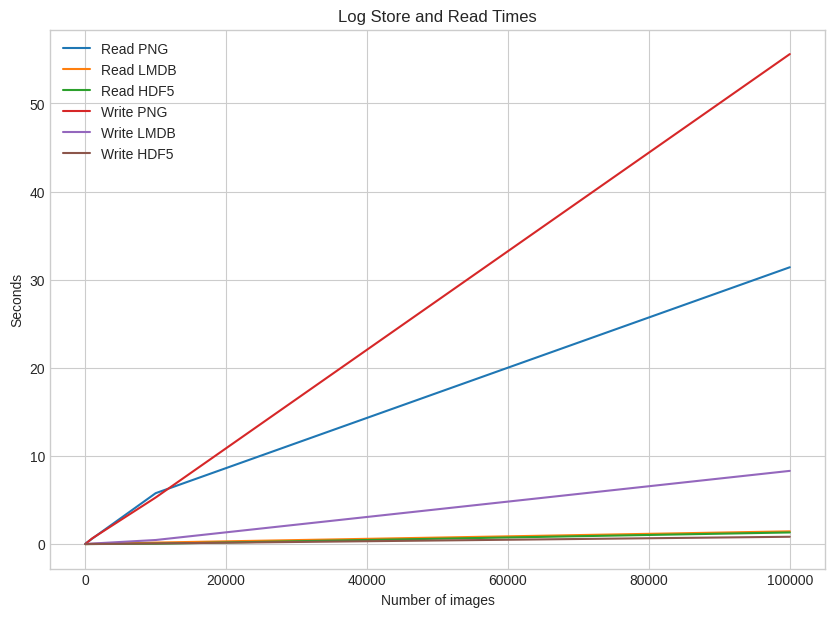

In [41]:
plot_with_legend(
    cutoffs,
    [disk_x_r, lmdb_x_r, hdf5_x_r, disk_x, lmdb_x, hdf5_x],
    [
        "Read PNG",
        "Read LMDB",
        "Read HDF5",
        "Write PNG",
        "Write LMDB",
        "Write HDF5",
    ],
    "Number of images",
    "Seconds",
    "Log Store and Read Times",
    log=False,
)

#**Kesimpulan**

Setiap sistem penyimpanan, baik itu format PNG, LMDB, maupun HDF5, memiliki kelemahan masing-masing. Namun, perlu diingat bahwa dalam LMDB, data baru ditulis tanpa mengganggu atau memindahkan data yang sudah ada. Pendekatan desain ini tidak hanya memungkinkan operasi pembacaan yang sangat cepat, tetapi juga menjamin integritas dan keandalan data tanpa memerlukan penyimpanan log transaksi tambahan. LMDB berhasil mencapai keseimbangan optimal antara kinerja, integritas data, dan keandalan operasi, menjadikannya pilihan yang kuat untuk aplikasi yang membutuhkan akses cepat dan aman terhadap data.

Di sisi lain, dalam situasi yang membutuhkan kinerja tinggi, penggunaan HDF5 dapat memberikan manfaat yang signifikan. Secara umum, dalam LMDB, kinerja yang lebih baik dapat diperoleh ketika mengakses item secara berurutan berdasarkan kunci. Ini disebabkan oleh penyimpanan pasangan nilai-kunci dalam memori yang diurutkan secara alfanumerik berdasarkan kunci, sehingga memungkinkan akses berurutan yang cepat dan efisien. Sebaliknya, dalam HDF5, mengakses rentang besar dalam kumpulan data akan lebih efisien daripada membaca setiap elemen secara terpisah. Struktur penyimpanan HDF5 memfasilitasi akses cepat ke rentang data, mengurangi overhead yang terkait dengan membaca setiap elemen secara terpisah.

Memahami struktur dan cara kerja dari masing-masing format penyimpanan sangat penting untuk mengoptimalkan kinerja dalam penggunaan sehari-hari.